### Set up

In [1]:
##https://github.com/zlatankr/Projects/tree/master/Tanzania

In [2]:
import pandas as pd
import numpy as np

from IPython.core.debugger import set_trace

import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
#import feature_process_helper
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

from sklearn.metrics import make_scorer

from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

/opt/anaconda/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [4]:
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, auc, accuracy_score)
from sklearn.model_selection import GridSearchCV

### Data

In [5]:
data_dir = os.getcwd()+'/data/'

train_data = pd.read_csv(f'{data_dir}train.csv' , index_col = 'new_ids') ##
test_data = pd.read_csv(f'{data_dir}test.csv' , index_col = 'new_ids') ## 



X_train = train_data.copy()
X_test = test_data.copy()
y_train = X_train[['defective']]
X_train.drop(columns=['defective'] , inplace=True)

print(X_train.shape)
print(X_test.shape)

(50000, 39)
(5083, 39)


In [6]:
y_train['defective'] = y_train['defective'].apply(lambda x: 1 if x=='yes' else 0)

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


###  Feature engineering

In [7]:
def dates(X_train, X_test):
    """
    date_recorded: this might be a useful variable for this analysis, although the year itself would be useless in a practical scenario moving into the future. We will convert this column into a datetime, and we will also create 'year_recorded' and 'month_recorded' columns just in case those levels prove to be useful. A visual inspection of both casts significant doubt on that possibility, but we'll proceed for now. We will delete date_recorded itself, since random forest cannot accept datetime
    """
    for i in [X_train, X_test]:
        i['date_recorded'] = pd.to_datetime(i['date_recorded'])
        i['year_recorded'] = i['date_recorded'].apply(lambda x: x.year)
        i['month_recorded'] = i['date_recorded'].apply(lambda x: x.month)
        i['date_recorded'] = (pd.to_datetime(i['date_recorded'])).apply(lambda x: x.toordinal())
    return X_train, X_test

def dates2(X_train, X_test):
    """
    Turn year_recorded and month_recorded into dummy variables
    """
    for z in ['month_recorded', 'year_recorded']:
        X_train[z] = X_train[z].apply(lambda x: str(x))
        X_test[z] = X_test[z].apply(lambda x: str(x))
        good_cols = [z+'_'+i for i in X_train[z].unique() if i in X_test[z].unique()]
        X_train = pd.concat((X_train, pd.get_dummies(X_train[z], prefix = z)[good_cols]), axis = 1)
        X_test = pd.concat((X_test, pd.get_dummies(X_test[z], prefix = z)[good_cols]), axis = 1)
        del X_test[z]
        del X_train[z]
    return X_train, X_test



def construction(X_train, X_test):
    for i in [X_train, X_test]:
        i['construction_year'].replace(0, X_train[X_train['construction_year'] != 0]['construction_year'].median(), inplace=True)
    return X_train, X_test


def bools(X_train, X_test):
    """
    public_meeting: we will fill the nulls as 'False'
    permit: we will fill the nulls as 'False
    """
    z = ['public_meeting', 'permit']
    for i in z:
        X_train[i].fillna(False, inplace = True)
        X_train[i] = X_train[i].apply(lambda x: float(x))
        X_test[i].fillna(False, inplace = True)
        X_test[i] = X_test[i].apply(lambda x: float(x))
    return X_train, X_test


def locs(X_train, X_test):
    """
    fill in the nulls for ['longitude', 'latitude', 'gps_height', 'population'] by using means from 
    ['subvillage', 'district_code', 'basin'], and lastly the overall mean
    """
    trans = ['longitude', 'latitude', 'gps_height', 'population']
    for i in [X_train, X_test]:
        i.loc[i.longitude == 0, 'latitude'] = 0
    for z in trans:
        for i in [X_train, X_test]:
            i[z].replace(0., np.NaN, inplace = True)
            i[z].replace(1., np.NaN, inplace = True)
        
        for j in ['subvillage', 'district_code', 'basin']:
        
            X_train['mean'] = X_train.groupby([j])[z].transform('mean')
            X_train[z] = X_train[z].fillna(X_train['mean'])
            o = X_train.groupby([j])[z].mean()
            fill = pd.merge(X_test, pd.DataFrame(o), left_on=[j], right_index=True, how='left').iloc[:,-1]
            X_test[z] = X_test[z].fillna(fill)
        
        X_train[z] = X_train[z].fillna(X_train[z].mean())
        X_test[z] = X_test[z].fillna(X_train[z].mean())
        del X_train['mean']
    return X_train, X_test


def removal2(X_train, X_test):
    z = ['amount_tsh',  'num_private', 'region', 
          'quantity', 'quality_group', 'source_type', 'payment', 
          'waterpoint_type_group',
         'extraction_type_group' , 'scheme_name'  ,'recorded_by']
    for i in z:
        del X_train[i]
        del X_test[i]
    return X_train, X_test



def small_n2(X_train, X_test):
    cols = [i for i in X_train.columns if type(X_train[i].iloc[0]) == str]
    #print(cols)
    X_train[cols] = X_train[cols].where(X_train[cols].apply(lambda x: x.map(x.value_counts())) > 100, "other")
    for column in cols:
        for i in X_test[column].unique():
            if i not in X_train[column].unique():
                X_test[column].replace(i, 'other', inplace=True)
    return X_train, X_test




def dummies(X_train, X_test):
    columns = [i for i in X_train.columns if type(X_train[i].iloc[0]) == str]
    for column in columns:
        X_train[column].fillna('NULL', inplace = True)
        good_cols = [column+'_'+i for i in X_train[column].unique() if i in X_test[column].unique()]
        X_train = pd.concat((X_train, pd.get_dummies(X_train[column], prefix = column)[good_cols]), axis = 1)
        X_test = pd.concat((X_test, pd.get_dummies(X_test[column], prefix = column)[good_cols]), axis = 1)
        del X_train[column]
        del X_test[column]
    return X_train, X_test


def lda(X_train, X_test, y_train, cols=[ 'gps_height', 'latitude', 'longitude']): ##'population',
    sc = StandardScaler()
    X_train_std = sc.fit_transform(X_train[cols])
    X_test_std = sc.transform(X_test[cols])
    lda = LDA(n_components=None)
    X_train_lda = lda.fit_transform(X_train_std, y_train.values.ravel())
    X_test_lda = lda.transform(X_test_std)
    
    X_train_lda = pd.DataFrame(X_train_lda , index = X_train.index)
    X_test_lda = pd.DataFrame(X_test_lda , index = X_test.index)
    
    X_train = pd.merge(X_train_lda , X_train , left_index=True , right_index = True)
    X_test  = pd.merge(X_test_lda , X_test , left_index=True , right_index=True)
    
    #X_train = pd.concat((pd.DataFrame(X_train_lda), X_train), axis=1)
    #X_test = pd.concat((pd.DataFrame(X_test_lda), X_test), axis=1)
    for i in cols:
        del X_train[i]
        del X_test[i]
    return X_train, X_test

def gini(p):
    return 1-(p**2 + (1-p)**2)

def impurity(X_train):
    imp = {}
    for i in X_train.columns[17:]:
        imp[i] = gini(X_train[i].mean())
    return imp


Created ordinal data feature and few month, yearly features. Missing value imputation have been taken care separately for separate features. 
For location features such as latitude , longitude , gps height and population , use mean value of sub village, district code and basin and finally the overall mean. 
For boolean features : public meeting and permit, fill null values with False.


In [8]:
X_train, X_test = dates(X_train, X_test)
#X_train, X_test = dates2(X_train, X_test)

X_train, X_test = construction(X_train, X_test)
X_train, X_test = bools(X_train, X_test)  

In [9]:
X_train, X_test = locs(X_train, X_test)
X_train['population'] = np.log(X_train['population'])
X_test['population'] = np.log(X_test['population'])

We are removing features which are mostly empty or constant- amount_tsh , num_private , scheme_name. Also for highly correlated features we are keeping only 1 feature ( refer EDA analysis).

Also for some of the categorical features ,we are clubbing very infrequent catergories( with count less than 100) into  a single catergory. This will be helpful to control size of one hot encode vectors as well.

In [10]:
X_train, X_test = removal2(X_train, X_test)
X_train, X_test = small_n2(X_train, X_test)

For numerical columns we are converting the features into LDA components

In [11]:
print(X_train.shape)
print(X_test.shape)

(50000, 30)
(5083, 30)


In [12]:
num_cols = ['date_recorded' , 'gps_height' , 'latitude' , 'longitude' , 'population']

In [13]:
cat_cols = list(set(X_train.columns) - set(num_cols))
print(len(cat_cols))

25


In [14]:
for c in cat_cols:
    X_train[c] = pd.Categorical(X_train[c])
    X_test[c] = pd.Categorical(X_test[c])
    
    X_train[c] = X_train[c].cat.codes
    X_test[c] = X_test[c].cat.codes
    X_train[c] = pd.Categorical(X_train[c])
    X_test[c] = pd.Categorical(X_test[c])
    

In [15]:
# X_train = X_train.reset_index()
# y_train = y_train.reset_index()
# X_test.reset_index(inplace=True)
X_train2 = pd.merge(X_train , y_train  , left_index = True , right_index = True)
X_train2.shape

(50000, 31)

In [16]:
X_train2.head(2)

,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region_code,...,management_group,payment_type,water_quality,quantity_group,source,source_class,waterpoint_type,year_recorded,month_recorded,defective
new_ids,,,,,,,,,,,,,,,,,,,,,
22379,734904,22,1517.0,17,29.833534,-4.385917,12,3,15,15,...,4,4,6,1,7,0,3,4,1,0
37562,734885,75,1080.0,71,29.681301,-4.705539,12,3,15,15,...,4,1,6,1,6,1,1,4,0,0


In [17]:
X_tr, X_val = train_test_split(X_train2, test_size=0.25,stratify=X_train2['defective'], random_state = 50)

In [18]:
y_tr = X_tr['defective']
y_val = X_val['defective']

X_tr.drop(columns=['defective'] , inplace=True)
X_val.drop(columns=['defective'] , inplace=True)

/opt/anaconda/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [19]:
X_tr.reset_index(inplace=True , drop = True)
X_val.reset_index(inplace=True , drop = True)

y_tr.reset_index(inplace=True , drop = True)
y_val.reset_index(inplace=True , drop = True)

X_test.reset_index(inplace=True , drop = True)

In [20]:
X_tr.head(2)

,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region_code,...,management,management_group,payment_type,water_quality,quantity_group,source,source_class,waterpoint_type,year_recorded,month_recorded
0,734943,75,974.0,71,35.885312,-3.373824,12,0,15,1,...,8,4,2,6,1,8,0,1,4,2
1,734931,75,739.0,71,37.555989,-3.424153,12,5,15,2,...,0,0,1,6,1,3,0,1,4,2


In [22]:
y_tr.head(2)

0    1
1    1
Name: defective, dtype: int64

In [23]:
X_val.head(2)

,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region_code,...,management,management_group,payment_type,water_quality,quantity_group,source,source_class,waterpoint_type,year_recorded,month_recorded
0,734796,22,999.704878,31,33.224735,-3.843816,12,0,15,16,...,5,4,2,6,3,7,0,3,3,9
1,734356,75,393.391304,71,31.655977,-1.834594,12,4,15,17,...,5,4,2,6,1,8,0,1,2,7


In [24]:
y_val.head(2)

0    1
1    1
Name: defective, dtype: int64

In [28]:
# tr_data = lgb.Dataset(X_tr, label=y_tr, free_raw_data=False, feature_name=list(X_tr.columns), categorical_feature='auto')
# val_data = lgb.Dataset(X_val , label= y_val , free_raw_data=False , feature_name=list(X_tr.columns) , categorical_feature='auto')

In [27]:
def custom_accuracy(y , ypred):
    #set_trace()
    
    misses = 1- (ypred ==y)
    false_pos = misses*(1-y)
    false_neg = misses *y
    false_pos_rate = false_pos.sum()/ (len(y) - int(y.sum()))
    false_neg_rate = false_neg.sum()/ (int(y.sum()))
    
    score = 1 - ( 0.9 * false_neg_rate  +  0.1 * false_pos_rate) 
    return score

In [25]:
params = { 'max_depth' : -1,
          'nthread': 3, 
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 20,
          'feature_name': 'auto', # that's actually the default
          'categorical_feature': 'auto' # that's actually the default
         }

In [40]:
fit_params={"early_stopping_rounds":50, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_val,y_val)],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': 'auto' # that's actually the default
           }

In [41]:
clf = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

clf.fit(X_tr,y_tr , **fit_params)

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	valid's binary_logloss: 0.662383	valid's auc: 0.822914


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_bin=512,
        max_depth=-1, min_child_samples=5, min_child_weight=1,
        min_split_gain=0.5, n_estimators=100, n_jobs=-1, num_leaves=31,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, scale_pos_weight=20, silent=True, subsample=1,
        subsample_for_bin=200, subsample_freq=1)

### Result on validation set

In [43]:
pred = clf.predict(X_val)
print( 'Custom accuracy on validation data set', custom_accuracy(y_val , pred))

Custom accuracy on validation data set 0.8683974090644453


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The custom accuracy has improved from Random Forest version by around 6%. We will further try hyper parameter tuning to improve it further.

In [53]:
param_grid = {
    'learning_rate': [0.05 , 0.1 , 1],
    'n_estimators': [40],
    'num_leaves': [30 , 50],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], 
    'colsample_bytree' : [ 0.9],
    'subsample' : [0.75],
    'reg_alpha' : [0.2, 0.6],
    'reg_lambda' : [0.2 , 0.4],
    'scale_pos_weight': [15 , 20 , 25]
    }

In [54]:
clf = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 12, # Updated from 'nthread'
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

In [55]:
from sklearn.model_selection import KFold
cv_5 = KFold(n_splits=5)

grid = GridSearchCV(clf ,param_grid=param_grid,
                scoring  = make_scorer(custom_accuracy),cv= cv_5,  n_jobs=12 , verbose = 5 , refit= True)  #n_iter = 100,

#gs = gs.fit(X_tr, y_tr.values.ravel())
grid.fit(X_tr, y_tr ,**fit_params)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_st

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.665809	valid's auc: 0.834611


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9026774780240234, total=   3.5s
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.8918924602223403, total=   3.4s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.664219	valid's auc: 0.828629
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.872691319050516, total=   3.7s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9080000219229736, total=   3.9s
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.664565	valid's auc: 0.829242[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.663944	valid's auc: 0.842774[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 


Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.667774	valid's auc: 0.82044


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.8898538285733077, total=   3.8s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.663902	valid's auc: 0.834051

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.875010668222376, total=   4.6s
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.851549488946217, total=   4.8s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.8715966764075139, total=   5.1s
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.658715	valid's auc: 0.846452[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.09999999999999998, total=   4.8s

[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.8860454346277877, total=   5.5s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.657951	valid's auc: 0.843312


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.8962841558484071, total=   6.5s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.8876365686855352, total=   7.3s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.667552	valid's auc: 0.831855Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.667067	valid's auc: 0.828773



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[6]	valid's binary_logloss: 0.656906	valid's auc: 0.848481Training until validation scores don't improve for 50 rounds.

Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.664584	valid's auc: 0.829243
Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.658366	valid's auc: 0.841851

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9010600287510163, total=   5.0s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.09999999999999998, total=   5.3s
Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.658626	valid's auc: 0.846562

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9080000219229736, total=   5.5s
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.662472	valid's auc: 0.831251[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.8715966764075139, total=   3.8s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.8920052506577113, total=   5.4s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.8938158214706597, total=   5.5s
Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.658167	valid's auc: 0.843441
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.872691319050516, total=   5.3s
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.8885591070670504, total=   6.5s
Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.668228	valid's auc: 0.823047
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.664234	valid's auc: 0.828603
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.657854	valid's auc: 0.844954


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.663957	valid's auc: 0.842776


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.666417	valid's auc: 0.824104
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.09999999999999998, total=   8.9s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.875010668222376, total=   6.1s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9026999146405816, total=   7.8s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.851549488946217, total=   6.0s
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.663851	valid's auc: 0.833612[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 

Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.667734	valid's auc: 0.820448

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.09999999999999998, total=   3.8s
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.667251	valid's auc: 0.831092


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.8861127444774624, total=   4.8s
Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.668248	valid's auc: 0.823042[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 

Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.66757	valid's auc: 0.831856[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.09999999999999998, total=   4.9s
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.09999999999999998, total=   5.2s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.09999999999999998, total=   5.4s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.658435	valid's auc: 0.842175
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.656915	valid's auc: 0.846538


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9010600287510163, total=   5.6s
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.657929	valid's auc: 0.844371
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.662474	valid's auc: 0.831255

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.8945787849097798, total=   5.2s

[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.658171	valid's auc: 0.843444

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.8977517990540237, total=   6.1s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9024041538781762, total=   4.4s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.663962	valid's auc: 0.842775


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.872691319050516, total=   4.4s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.664263	valid's auc: 0.830042Training until validation scores don't improve for 50 rounds.



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.8885821697976778, total=   5.4s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.851549488946217, total=   3.6s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.8748928343762005, total=   5.6s
Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.658633	valid's auc: 0.846559
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.665729	valid's auc: 0.835075
Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.667734	valid's auc: 0.820456Training until validation scores don't improve for 50 rounds.



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.663736	valid's auc: 0.834782[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.8938158214706597, total=   8.0s

Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.667594	valid's auc: 0.831849[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.09999999999999998, total=   4.5s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.8897042042782684, total=   5.5s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.664245	valid's auc: 0.828614
Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.66814	valid's auc: 0.822981


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.8872733509105263, total=   6.3s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9010600287510163, total=   4.5s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.875010668222376, total=   8.0s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.09999999999999998, total=   5.3s
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.658462	valid's auc: 0.842152
Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.658646	valid's auc: 0.84657
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.656967	valid's auc: 0.845478
Training until validation scores don't improve

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.667256	valid's auc: 0.831083


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.8938158214706597, total=   5.3s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.8948722312743054, total=   6.0s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.8986037258093688, total=   7.1s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.09999999999999998, total=   8.0s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.658185	valid's auc: 0.843421


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:   28.2s
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.8885821697976778, total=   6.7s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.664281	valid's auc: 0.830042
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.662493	valid's auc: 0.831251
Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.657945	valid's auc: 0.844371

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.665748	valid's auc: 0.83512Training until validation scores don't improve for 50 rounds.

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.663856	valid's auc: 0.833599
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.66429	valid's auc: 0.828616

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.874937950550349, total=   6.2s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9024041538781762, total=   7.3s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.872691319050516, total=   6.9s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.8897042042782684, total=   5.1s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.8861392658411693, total=   5.8s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.875010668222376, total=   6.4s
Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.66816	valid's auc: 0.822993[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 

Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.09999999999999998, total=   4.1s
Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.667723	valid's auc: 0.820475[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 

Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.09999999999999998, total=   5.2s
Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.667274	valid's auc: 0.831016
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.663913	valid's auc: 0.842316[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 

Did not meet early stopping. Best iteration is:
[6]	valid's binary_logloss: 0.65067	valid's auc: 0.856446
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.667611	valid's auc: 0.831863


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9070049381498106, total=   5.4s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.09999999999999998, total=   5.8s
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9010600287510163, total=   5.7s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.851887761766366, total=   9.3s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
Did not meet early stopping. Best iteration is:
[6]	valid's binary_logloss: 0.652035	valid's auc: 0.856149
Did not meet early stopping. Best iterati

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[7]	valid's binary_logloss: 0.652008	valid's auc: 0.855332


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9040711397987242, total=   5.7s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9021359412393113, total=   6.0s
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.660726	valid's auc: 0.841345

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 

[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9025488652517272, total=   6.2s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.658492	valid's auc: 0.85056


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9129067982358317, total=   6.2s
Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.659671	valid's auc: 0.844842[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.8732655923858843, total=   6.6s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.9011134837960263, total=   4.7s
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.9050293215361305, total=   6.2s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.663187	valid's auc: 0.830516
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.658959	valid's auc: 0.850443
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.657019	valid's auc: 0.848057


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.8888802633794123, total=   5.6s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.662856	valid's auc: 0.843107
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.663386	valid's auc: 0.84096


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.908084820585592, total=   6.6s
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.906259666661186, total=  10.2s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.8857529762876643, total=   4.8s
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9005827031898115, total=   4.8s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
Did not meet early stopping. Best iteration is:
[6]	valid's binary_logloss: 0.650721	valid's auc: 0.856426

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.661313	valid's auc: 0.839706


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[6]	valid's binary_logloss: 0.652122	valid's auc: 0.855848


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9069820286423651, total=   5.9s
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9025037490775787, total=   6.0s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.8948337416487172, total=   9.4s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9031872556538656, total=   5.9s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
Did not meet early stopping. Best iteration is:
[7]	valid's binary_logloss: 0.652176	valid's auc: 0.854971


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.664204	valid's auc: 0.830628Training until validation scores don't improve for 50 rounds.



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.658506	valid's auc: 0.85011

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.

[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9124539811575185, total=   6.5s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.65975	valid's auc: 0.84492


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.8933396199811842, total=  11.6s
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
Did not meet early stopping. Best iteration is:
[6]	valid's binary_logloss: 0.651479	valid's auc: 0.853351


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.658935	valid's auc: 0.850456


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.9014133284506044, total=   4.2s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.9054658125853458, total=   5.1s
Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.657084	valid's auc: 0.847956Training until validation scores don't improve for 50 rounds.



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9024588486245165, total=   8.7s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.908739567212929, total=   4.7s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.661409	valid's auc: 0.839541


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.663277	valid's auc: 0.844795[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.9055373046800068, total=   7.3s

[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.8974647177143108, total=   5.0s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.8768658069798144, total=   4.6s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.664242	valid's auc: 0.82886
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.660702	valid's auc: 0.843611
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.663209	valid's auc: 0.830459Did not meet early stopping. Best iteration is:
[6]	valid's binary_logloss: 0.652125	valid's auc: 0.855847



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.8934072942424068, total=   7.3s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 
Did not meet early stopping. Best iteration is:
[6]	valid's binary_logloss: 0.653357	valid's auc: 0.851596


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[6]	valid's binary_logloss: 0.650734	valid's auc: 0.856226[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.90379223729666, total=  10.3s

[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.8888802633794123, total=   7.7s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9029460953721544, total=   4.6s
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.663456	valid's auc: 0.840958[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9037232244075118, total=   5.6s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9070507571647018, total=   6.6s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9011517880980643, total=   7.2s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[6]	valid's binary_logloss: 0.651515	valid's auc: 0.853672
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.659752	valid's auc: 0.844837
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.660482	valid'

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[7]	valid's binary_logloss: 0.652164	valid's auc: 0.85497
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9022128267268766, total=   7.4s
Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.657037	valid's auc: 0.848067
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.9046048431975907, total=   5.5s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.8721818480435181, total=   6.2s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9125212910071931, total=   8.0s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.659314	valid's auc: 0.842467


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.658688	valid's auc: 0.850349[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.9058243860197197, total=   7.5s

[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.663133	valid's auc: 0.829982

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.664037	valid's auc: 0.827982


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.9020206567425978, total=   5.5s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.891271212390557, total=   5.0s
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.8892589122037449, total=   4.5s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.8952811453300531, total=   5.5s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.663464	valid's auc: 0.840968
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.66332	valid's auc: 0.843626

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.661403	valid's auc: 0.839523


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9005827031898115, total=   6.5s
Did not meet early stopping. Best iteration is:
[6]	valid's binary_logloss: 0.650641	valid's auc: 0.855875Did not meet early stopping. Best iteration is:
[6]	valid's binary_logloss: 0.652173	valid's auc: 0.855849

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[6]	valid's binary_logloss: 0.651578	valid's auc: 0.853723
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 




/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.8767735560573052, total=   7.3s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.8974188986994196, total=   8.7s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9028086068295329, total=   5.4s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9023127749450693, total=   5.3s
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9063148029398708, total=   5.9s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objecti

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.87486874642864, total=   6.2s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9035423772457966, total=   8.6s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.9043178534016723, total=   6.3s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.9065130962363736, total=   6.7s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
Did not meet early stopping. Best iteration is:
[7]	valid's binary_logloss: 0.652248	valid's auc: 0.854921
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.664096	valid's auc: 0.827969


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.658862	valid's auc: 0.849534

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.663823	valid's auc: 0.840754
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9126477412122453, total=   9.6s
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.8952811453300531, total=   4.8s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.659254	valid's auc: 0.848364[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.9016208930262501, total=   8.4s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.661466	valid's auc: 0.839536[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9010926477426868, total=   4.9s

[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.9081337785658571, total=   6.9s
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.657871	valid's auc: 0.838417[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.8974188986994196, total=   7.4s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.8146245119214782, total=   3.9s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.663303	valid's auc: 0.844977
Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.663288	valid's auc: 0.830145
Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.658613	valid's auc: 0.839914


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.658868	valid's auc: 0.831722
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.657887	valid's auc: 0.835333

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.8769042351453856, total=   8.6s
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.05, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.8879603411025272, total=   9.0s
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.659844	valid's auc: 0.826759
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9088039373660644, total=   6.7s
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.8583657809632546, total=   6.6s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.855492152677231, total=   5.1s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.663895	valid's auc: 0.817967


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.8296812159786005, total=   7.3s
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.664204	valid's auc: 0.828421
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.662921	valid's auc: 0.819314Training until validation scores don't improve for 50 rounds.



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.8812111852073552, total=   5.3s
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.867171529569278, total=   4.9s
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.664383	valid's auc: 0.819334
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.8880089007272947, total=   6.3s
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.6642	valid's auc: 0.825043Training until validation scores don't improve for 50 rounds.



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.8832571375610859, total=   5.6s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.669134	valid's auc: 0.814626
Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.658012	valid's auc: 0.836672


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.667765	valid's auc: 0.821039[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.8688430599239733, total=   8.1s

[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.658882	valid's auc: 0.83173
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.8866935700723919, total=   5.4s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.66648	valid's auc: 0.818607[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9057928169376894, total=   4.3s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 

Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.659856	valid's auc: 0.826763[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.8584334552244772, total=   4.4s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.8939639206758692, total=   5.3s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.669234	valid's auc: 0.820489

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9025203746636193, total=   8.3s
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.8296812159786005, total=   4.2s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.8978153003847966, total=   7.7s
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9049396685058105, total=   7.3s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:  1.4min


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.664221	valid's auc: 0.825048
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.662917	valid's auc: 0.820347
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.658617	valid's auc: 0.836015


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.657896	valid's auc: 0.835332

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.8860558926212752, total=   5.6s
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.664396	valid's auc: 0.819354
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.8688430599239733, total=   4.2s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.664217	valid's auc: 0.828363[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.8164619205452485, total=   7.0s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.855492152677231, total=   7.1s

[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
[CV]

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.666921	valid's auc: 0.818806


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.8832571375610859, total=   4.1s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.867171529569278, total=   4.7s
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.669156	valid's auc: 0.788116
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.664197	valid's auc: 0.818273


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9027387274809955, total=   4.8s
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.09999999999999998, total=   5.2s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.8790298406255261, total=   6.3s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.667207	valid's auc: 0.82595
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.659853	valid's auc: 0.826763


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.668042	valid's auc: 0.824511
Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.658021	valid's auc: 0.836672


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.662917	valid's auc: 0.820347Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.658883	valid's auc: 0.831727



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.8813941785119495, total=   6.8s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.8296812159786005, total=   4.8s
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9049396685058105, total=   7.0s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.669157	valid's auc: 0.814602
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.905815726445135, total=   5.4s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.6579	valid's auc: 0.83533[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.8584334552244772, total=   5.6s



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.8860558926212752, total=   4.3s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.664008	valid's auc: 0.825174
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.8866935700723919, total=   9.5s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.855492152677231, total=   5.5s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.664227	valid's auc: 0.818146
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.8703555991533105, total=   5.7s
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.8785016905478965, total=   5.2s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.667205	valid's auc: 0.82595Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.658646	valid's auc: 0.834324

Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.66637	valid's auc: 0.819351
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.664218	valid's auc: 0.828415


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.669157	valid's auc: 0.788116


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.8813941785119495, total=   3.6s
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.8162006206819337, total=   9.8s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.66917	valid's auc: 0.814601


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.867171529569278, total=   8.0s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9027373024877094, total=   4.9s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.09999999999999998, total=   5.2s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.664345	valid's auc: 0.819289Did not meet early stopping. Best iteration 

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.8866935700723919, total=   5.4s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.659865	valid's auc: 0.826764Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.905815726445135, total=   4.9s
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.883646729536873, total=   7.0s
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.658653	valid's auc: 0.834312Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.658896	valid's auc: 0.831733
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 

Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.66803	valid's auc: 0.824462


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.8296812159786005, total=   5.0s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.8584334552244772, total=   6.1s
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.901647524514197, total=   7.3s
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.8162006206819337, total=   5.1s
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6,

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.657909	valid's auc: 0.835338


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.8860558926212752, total=   4.1s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.66403	valid's auc: 0.825176Training until validation scores don't improve for 50 rounds.

Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.8785016905478965, total=   3.4s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.855492152677231, total=   4.7s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.666388	valid's auc: 0.819357
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.669167	valid's auc: 0.788116Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.664231	valid's auc: 0.828357Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.664358	valid's auc: 0.819359




/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.8703555991533105, total=   4.5s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.867171529569278, total=   5.5s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.883646729536873, total=   5.1s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.669193	valid's auc: 0.814592

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9027373024877094, total=   4.0s

[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.09999999999999998, total=   4.0s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.668045	valid's auc: 0.824472


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.8866935700723919, total=   4.6s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9010784396059444, total=   4.5s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.652063	valid's auc: 0.848753Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.653496	valid's auc: 0.845076

Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.651336	valid's auc: 0.850543
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9079570528946546, total=   6.4s
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.66723	valid's auc: 0.825487[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9040640817369153, total=   5.3s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.659099	valid's auc: 0.841243Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.657955	valid's auc: 0.830718



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9089705566777538, total=   5.6s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.652783	valid's auc: 0.846099
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.654481	valid's auc: 0.84494


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.8811404884750491, total=   7.6s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.8827276563793113, total=   4.8s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.8629276081003541, total=   4.7s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9074464129468494, total=   6.0s
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.659934	valid's auc: 0.833608Training until validation scores don't improve for 50 rounds.

[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9042513304588563, total=   7.5s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.8864239417123403, total=   6.3s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.661637	valid's auc: 0.826094


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9043488602794083, total=   6.4s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.660632	valid's auc: 0.832665
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.665424	valid's auc: 0.823538


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.66305	valid's auc: 0.836479


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.664301	valid's auc: 0.818532[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.8811246033855077, total=   9.7s

[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.8897969430073568, total=   5.5s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.8974289444161232, total=   6.7s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.654451	valid's auc: 0.84491


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.8958347460203147, total=   7.2s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.664733	valid's auc: 0.827208[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9045263075440992, total=   5.8s

Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.659511	valid's auc: 0.831963[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.651778	valid's auc: 0.849883


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.653849	valid's auc: 0.844706


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9030692008516624, total=   7.7s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9083478337943935, total=   7.1s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.8935965689893517, total=  12.1s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.652111	valid's auc: 0.848679


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9017618182274199, total=   8.3s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.660686	valid's auc: 0.832668


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.652843	valid's auc: 0.846055


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.8811246033855077, total=   5.1s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9074974377524567, total=  10.3s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.659491	valid's auc: 0.832566


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.659956	valid's auc: 0.833591[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9074464129468494, total=   9.2s

[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.659091	valid's auc: 0.841518

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.8931845403970065, total=   5.4s
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.657995	valid's auc: 0.830538

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.8861827814306291, total=   6.1s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.8626892834983976, total=   6.6s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.661603	valid's auc: 0.826063


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.8818177433587091, total=   9.4s
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.665567	valid's auc: 0.82349


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9043488602794083, total=   6.8s
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.8981739349872547, total=   6.1s
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.664355	valid's auc: 0.818593
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.66309	valid's auc: 0.829845[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.651872	valid's auc: 0.848866


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.651564	valid's auc: 0.850192[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.8857147813734775, total=   7.3s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.8958347460203147, total=   7.2s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9071280356467551, total=   5.4s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.652881	valid's auc: 0.846041


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9094472058816669, total=   4.9s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.664968	valid's auc: 0.82823Training until validation scores don't improve for 50 rounds.

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.653706	valid's auc: 0.845076


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9069670745048295, total=   5.5s
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.657891	valid's auc: 0.830529[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.653998	valid's auc: 0.844664


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.903754553589855, total=   9.3s
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9001592378823465, total=   8.1s
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Did not meet early stopping. Best iteration is:
[

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.8818406528661548, total=   6.5s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9054549105389177, total=   8.0s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.8775118672675389, total=   6.4s
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.66559	valid's auc: 0.82349[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 

Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.659968	valid's auc: 0.833588

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.8981739349872547, total=   4.5s
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.661602	valid's auc: 0.825969

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.8861827814306291, total=   7.8s
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.663086	valid's auc: 0.829889[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 

Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.664342	valid's auc: 0.81864
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.659098	valid's auc: 0.84152[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9041884937272892, total=   6.3s



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.8857147813734775, total=   4.6s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.8958347460203147, total=   5.4s
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.8912937079926336, total=   7.1s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.8626892834983976, total=   9.1s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.651893	valid's auc: 0.848714
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.654034	valid's auc: 0.844332
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.664979	valid's auc: 0.828233

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.908033673687499, total=   7.0s
Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.652939	valid's auc: 0.84608[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 

Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.652217	valid's auc: 0.850369


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.903754553589855, total=   8.3s
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9025295581181862, total=   7.6s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9069670745048295, total=   5.2s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9080710810268658, total=   7.1s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[3]	valid's binary_logloss: 0.654063	valid's auc: 0.844629
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.660233	valid's auc: 0.832606Training until val

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.659476	valid's auc: 0.829806
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.65793	valid's auc: 0.830527


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9053861662676069, total=  10.1s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.659129	valid's auc: 0.841535[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.8775118672675389, total=   6.4s

[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.661671	valid's auc: 0.826024


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.8819093813884915, total=   8.2s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.8912937079926336, total=   6.8s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.8626892834983976, total=   7.4s
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9042114032347348, total=   6.7s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 
Training until validation scores don't improve for 5

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.660442	valid's auc: 0.833586


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9100630833566264, total=   5.1s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 
Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.665029	valid's auc: 0.828242


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.8984446320321453, total=   7.1s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.8854134710712882, total=  10.7s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.90753	valid's auc: 0.816015[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 

Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.664189	valid's auc: 0.823005Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.928978	valid's auc: 0.863596

Did not meet early stopping. Best iteration is:
[2]	valid's binary_logloss: 0.663158	valid's auc: 0.829694
Did not meet early stopping. Best iteration is:
[11]	valid's binary_logloss: 0.900332	valid's auc: 0.873485

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9037994268229714, total=   6.7s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.967529	valid's auc: 0.794847

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9092017379560647, total=   4.4s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.8861173691520605, total=   7.7s
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.971272	valid's auc: 0.801695[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
Training until validation scores don't improve for 50 rounds.



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.905440881095793, total=   5.1s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.8846000438512602, total=   7.9s
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.906017	valid's auc: 0.81477

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9090482715849524, total=   5.8s
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.9110861189211704, total=   4.5s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.9093350321649489, total=   4.6s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9115404134486687, total=   5.8s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1]	valid's bin

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.987129	valid's auc: 0.804072
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.02149	valid's auc: 0.782963
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.0331	valid's auc: 0.786027Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.03093	valid's auc: 0.785557



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9103007283907989, total=   4.9s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.90869427972839, total=   6.5s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[9]	valid's binary_logloss: 0.903018	valid's auc: 0.874758Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.912026	valid's auc: 0.810449


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.9093556838697338, total=   6.5s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9111468546967698, total=   4.9s
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9089174628313919, total=   5.2s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9072081525093997, total=   5.0s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9097638270519198, total=   5.2s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.909905926738248, total=   4.9s
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
Did not meet early stopping. Best iteration is:
[8]	valid's binary_logloss: 0.912709	valid's auc: 0.871514Training until validation scores don't improve for 50 rounds.

Did not meet early stopping. Best iteration is:
[1]	valid's binary_

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.9090724446127826, total=   9.1s
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9045980148747376, total=   6.9s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1]	vali

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.964841	valid's auc: 0.795011

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.90869427972839, total=   3.4s
Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.9093350321649489, total=   3.7s
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.967582	valid's auc: 0.801784


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9088855915165117, total=   9.8s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.9107653858169322, total=   4.7s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9115404134486687, total=   5.0s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.01208	valid's auc: 0.794278


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.9090724446127826, total=   4.7s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[11]	valid's binary_logloss: 0.90469	valid's auc: 0.873756
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.03305	valid's auc: 0.786027

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.

[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9102455921121141, total=   4.9s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 


[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed:  2.6min


Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.987043	valid's auc: 0.803946


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9072081525093997, total=   4.0s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9008904663161676, total=  11.0s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.9093556838697338, total=   7.3s
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.02142	valid's auc: 0.782969[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.02098	valid's auc: 0.788116

Did not meet early stopping. Best iteration is:
[12]	valid's binary_logloss: 0.894489	valid's auc: 0.876741


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.918829	valid's auc: 0.812323Did not meet early stopping. Best iteration is:
[6]	valid's binary_logloss: 0.906619	valid's auc: 0.874192
Training until validation scores don't improve for 50 rounds.



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9111468546967698, total=   4.3s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.904837118165323, total=   4.1s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9094946598675155, total=   7.9s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.905904	valid's auc: 0.81477
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.964761	valid's auc: 0.795022


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.911450697972673, total=   5.1s
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9100628145978046, total=   4.7s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.911994	valid's auc: 0.810449


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9115404134486687, total=   4.9s
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.9107653858169322, total=   3.9s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 ro

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.971861	valid's auc: 0.793085
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.987008	valid's auc: 0.804066


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9097638270519198, total=   6.8s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.90869427972839, total=   4.7s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.9093556838697338, total=   4.3s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.968381	valid's auc: 0.801921
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.01424	valid's auc: 0.795241Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.966767	valid's auc: 0.801759Training until validation scores don't improve for 50 rounds.




/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.01417	valid's auc: 0.795241

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.9107571478134285, total=   6.5s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.909194810070686, total=   4.6s
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9075336115244844, total=  11.6s
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.03307	valid's auc: 0.786027Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.02143	valid's auc: 0.78297

[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=bi

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9075336115244844, total=   4.6s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9111468546967698, total=   4.4s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9072081525093997, total=   5.3s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9094946598675155, total=   5.9s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
Did not meet early stopping. Best iteration is:
[11]	valid's binary_logloss: 0.900782	valid's auc: 0.871135
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9103236378982444, total=   6.3s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
Did not meet early stopping. Best iteration is:
[29]	valid's binary_logloss: 0.882372	valid's auc: 0.875898


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.8913537984292189, total=   4.8s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.8952281886209124, total=   4.9s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.8995360346246656, total=   4.3s
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.968299	valid's auc: 0.801921


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[9]	valid's binary_logloss: 0.904889	valid's auc: 0.871509
Did not meet early stopping. Best iteration is:
[13]	valid's binary_logloss: 0.893783	valid's auc: 0.874902


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.9107571478134285, total=   3.6s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.966682	valid's auc: 0.801759


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9065180933098838, total=   6.1s
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9050639288734923, total=   4.9s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.02087	valid's auc: 0.788116


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.909194810070686, total=   4.2s
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9094946598675155, total=   4.1s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.00372	valid's auc: 0.794682Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.986923	valid's auc: 0.803946Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.964663	valid's auc: 0.795022


Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.03302	valid's auc: 0.785965Did not me

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.9107653858169322, total=   7.2s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9103236378982444, total=   6.0s
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.02136	valid's auc: 0.782898[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 

[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.9093556838697338, total=   6.6s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9075336115244844, total=   4.8s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9072081525093997, total=   6.2s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.893666	valid's auc: 0.814211
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9111468546967698, total=   5.7s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.971798	valid's auc: 0.793074
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9096772390207007, total=   4.9s
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.894149	valid's auc: 0.821502Training until validation scores don't improve for 50 rounds.



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=30, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.90869427972839, total=   9.5s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.894892	valid's auc: 0.819486
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.911269773886108, total=   4.7s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[6]	valid's binary_logloss: 0.902403	valid's auc: 0.869952
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.888729	valid's auc: 0.817335


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9103933499318293, total=   6.3s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9039652467311398, total=   6.9s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9106959325282351, total=   6.1s
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.942389	valid's auc: 0.809163
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.960271	valid's auc: 0.815535
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.954335	valid's auc: 0.812872
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.960685	valid's auc: 0.804365[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.9091437802240875, total=   5.4s

[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.9090865700850435, total=   5.6s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.9103509110135318, total=   7.1s
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.9094493560485606, total=   7.1s
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.00121	valid's auc: 0.802755Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.00362	valid's auc: 0.807025

[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.944386	valid's auc: 0.809119Training until validation scores don't improve for 50 rounds.



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9107573390459893, total=   6.6s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9096477729157822, total=   5.5s
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.00776	valid's auc: 0.797247
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.9115858531051152, total=   8.9s
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.00519	valid's auc: 0.791677[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 

Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9120320651176529, total=   6.1s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9092115277595915, total=   7.7s
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.988528	valid's auc: 0.795348
Did not meet early stopping. Best iteration is:
[13]	valid's binary_logloss: 0.892633	valid's auc: 0.871076


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[7]	valid's binary_logloss: 0.883148	valid's auc: 0.871873


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9104568199630598, total=  10.8s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.8896929773284199, total=   5.6s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
Did not meet early stopping. Best iteration is:
[11]	valid's binary_logloss: 0.884484	valid's auc: 0.874351[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.959075	valid's auc: 0.815613
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.888625	valid's auc: 0.817339

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9038335288195928, total=   7.9s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.8989753202124336, total=   8.8s
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.954205	valid's auc: 0.812878[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
Training until validation scores don't improve for 50 rounds.



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.9099552857096207, total=   4.5s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.961167	valid's auc: 0.804517[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9106959325282351, total=   6.6s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Did not meet early stopping. Best iteration is:
[4]	valid's binary_logloss: 0.897363	valid's auc: 0.870798[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 

Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.943612	valid's auc: 0.809114Training until validation scores don't improve for 50 rounds.



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.942282	valid's auc: 0.809256

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.9103509110135318, total=   5.8s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.9093118675059392, total=   5.9s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9061414214805865, total=   8.6s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.9094272867450471, total=   5.1s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.9110804189480262, total=   8.2s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.987743	valid's auc: 0.795335
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[6]	valid's binary_logloss: 0.887691	valid's auc: 0.871106
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.00114	valid's auc: 0.802762


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9107317340524068, total=   7.4s
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.00772	valid's auc: 0.797268[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.904373962084217, total=   4.1s
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.00512	valid's auc: 0.791681[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9107573390459893, total=   6.3s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[5]	valid's binary_logloss: 0.894451	valid's auc: 0.874124


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9117322196080987, total=   5.4s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9092115277595915, total=   7.2s
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9043500508488018, total=   4.5s
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.951253	valid's auc: 0.811148[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 

Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[9]	valid's binary_logloss: 0.874377	valid's auc: 0.872855
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.943505	valid's auc: 0.809158


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.9112079270897913, total=   5.3s
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.00319	valid's auc: 0.799905[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.902016177117043, total=   7.4s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.888551	valid's auc: 0.817339[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.9110804189480262, total=   6.4s

[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75 
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.961137	valid's auc: 0.804517Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.894712	valid's auc: 0.819498
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.2, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9084638180452601, total=   9.7s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.959015	valid's auc: 0.815613
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.987376	valid's auc: 0.795265


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9103933499318293, total=   9.1s
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=15, subsample=0.75, score=0.9106959325282351, total=   7.5s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.9093118675059392, total=   5.1s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9110524671566451, total=   4.6s
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.9099552857096207, total=   5.4s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 
Did not meet early stopping. Best iteration is:
[1]	vali

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.00112	valid's auc: 0.802762


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=20, subsample=0.75, score=0.9096924413965972, total=   6.6s
Training until validation scores don't improve for 50 rounds.
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.00299	valid's auc: 0.799948


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9107573390459893, total=   6.5s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[6]	valid's binary_logloss: 0.89381	valid's auc: 0.875054


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9084868807758875, total=   5.3s
Did not meet early stopping. Best iteration is:
[9]	valid's binary_logloss: 0.892418	valid's auc: 0.871096[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75 



/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[14]	valid's binary_logloss: 0.874076	valid's auc: 0.873598
Did not meet early stopping. Best iteration is:
[8]	valid's binary_logloss: 0.886695	valid's auc: 0.876435
Did not meet early stopping. Best iteration is:
[10]	valid's binary_logloss: 0.880341	valid's auc: 0.87197

/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.90595666626042, total=   5.3s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9030419924615125, total=   5.2s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9008810843102758, total=   6.7s
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.00401	valid's auc: 0.791703[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.9003599068860474, total=   5.7s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=15, subsample=0.75, score=0.8943021685067322, total=   5.4s
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
[CV] boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75 
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.943369	valid's auc: 0.809199


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.961034	valid's auc: 0.80452
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.00769	valid's auc: 0.797272Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.
[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9093719310593165, total=   9.9s
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.9110804189480262, total=   6.6s
Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training until validation scores don't improve for 50 rounds.


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.9093118675059392, total=   5.3s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.2, scale_pos_weight=25, subsample=0.75, score=0.9117322196080987, total=   9.1s
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.943242	valid's auc: 0.804421
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.951339	valid's auc: 0.81116


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.9114335079605334, total=   8.8s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.9096924413965972, total=   4.9s
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.958868	valid's auc: 0.815612


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=20, subsample=0.75, score=0.9099552857096207, total=   6.8s
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.00066	valid's auc: 0.793115


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.987596	valid's auc: 0.795374
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.00105	valid's auc: 0.80277


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9093610290128884, total=   4.6s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9110295576491996, total=   5.6s


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9107573390459893, total=   5.2s
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.0034	valid's auc: 0.799705


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9084638180452601, total=   5.5s
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 1.00761	valid's auc: 0.797309


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  boosting_type=gbdt, colsample_bytree=0.9, learning_rate=1, n_estimators=40, num_leaves=50, objective=binary, random_state=501, reg_alpha=0.6, reg_lambda=0.4, scale_pos_weight=25, subsample=0.75, score=0.9117322196080987, total=   6.1s


[Parallel(n_jobs=12)]: Done 360 out of 360 | elapsed:  3.5min finished


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.984315	valid's auc: 0.810712


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_bin=512,
        max_depth=-1, min_child_samples=5, min_child_weight=1,
        min_split_gain=0.5, n_estimators=100, n_jobs=12, num_leaves=31,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, scale_pos_weight=20, silent=True, subsample=1,
        subsample_for_bin=200, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=12,
       param_grid={'learning_rate': [0.05, 0.1, 1], 'n_estimators': [40], 'num_leaves': [30, 50], 'boosting_type': ['gbdt'], 'objective': ['binary'], 'random_state': [501], 'colsample_bytree': [0.9], 'subsample': [0.75], 'reg_alpha': [0.2, 0.6], 'reg_lambda': [0.2, 0.4], 'scale_pos_weight': [15, 20, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
  

In [56]:
grid.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
        importance_type='split', learning_rate=1, max_bin=512,
        max_depth=-1, min_child_samples=5, min_child_weight=1,
        min_split_gain=0.5, n_estimators=40, n_jobs=12, num_leaves=50,
        objective='binary', random_state=501, reg_alpha=0.2,
        reg_lambda=0.2, scale_pos_weight=25, silent=True, subsample=0.75,
        subsample_for_bin=200, subsample_freq=1)

In [49]:
grid.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
        importance_type='split', learning_rate=0.1, max_bin=512,
        max_depth=-1, min_child_samples=5, min_child_weight=1,
        min_split_gain=0.5, n_estimators=40, n_jobs=12, num_leaves=50,
        objective='binary', random_state=501, reg_alpha=0.6, reg_lambda=1,
        scale_pos_weight=20, silent=True, subsample=0.75,
        subsample_for_bin=200, subsample_freq=1)

In [57]:
clf = grid.best_estimator_
clf.fit(X_tr , y_tr , **fit_params);

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1]	valid's binary_logloss: 0.984315	valid's auc: 0.810712


### Custom accuracy has imporved to 91% on validation set

In [58]:
pred = clf.predict(X_val)
print( 'Custom accuracy on validation data set', custom_accuracy(y_val , pred))

Custom accuracy on validation data set 0.9106670750028105


/opt/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


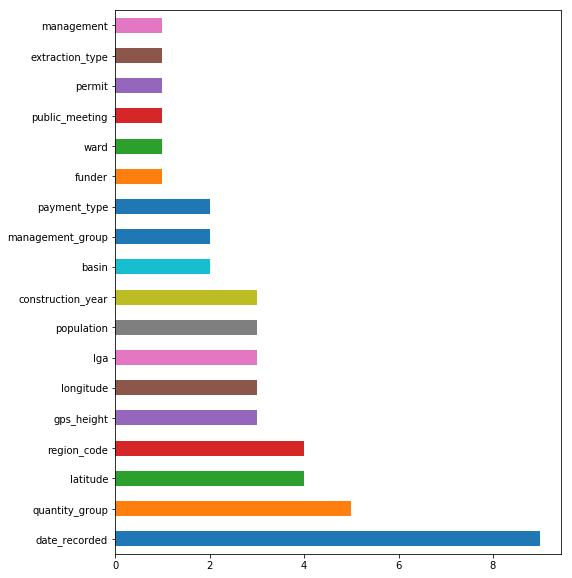

In [60]:
feat_imp = pd.Series(clf.feature_importances_, index=X_tr.columns)
feat_imp.nlargest(18).plot(kind='barh', figsize=(8,10))

We have been able to get very good results from Light GBM  . Along with that feature importance is showing clear segregations as agaoins RF model.
Date recorded and quality group are also coming important features.